This is a mini project for Machine Vision. Here the goal is an image classifier

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
from pathlib import Path
import tensorflow as tf
from keras import layers, models
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Shoe vs Sandal vs Boot Dataset.zip to Shoe vs Sandal vs Boot Dataset.zip


In [ ]:
import zipfile
import io
import os

# Extract the uploaded ZIP file into /content/data
zip_ref = zipfile.ZipFile(io.BytesIO(next(iter(uploaded.values()))))
zip_ref.extractall('/content/data')
zip_ref.close()


In [ ]:
path = "/content/data/Shoe vs Sandal vs Boot Dataset" # Initialize path to fix the NameError.

if not Path(path).exists():
    # Find the most recently modified directory under /content/data
    candidates = [d for d in Path('/content/data').iterdir() if d.is_dir()]
    if candidates:
        path = str(max(candidates, key=lambda p: p.stat().st_mtime))
        print("Auto-detected dataset folder:", path)
    else:
        raise FileNotFoundError("No folder found in /content/data after unzip. Check your ZIP content.")

In [ ]:
# Setting the directory paths
path = "/content/data/Shoe vs Sandal vs Boot Dataset"

In [ ]:
# Setting the directory paths
source_dir = Path(path) # Source directory of the dataset
dest_dir = Path("/content/split_data") # Destination directory for organized dataset
# dest_dir is where the split dataset will be saved. Change it to your desired path.
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [ ]:
# Splitting the dataset into training, validation, and test sets
splitfolders.ratio(
    source_dir,
    output=dest_dir,
    seed=42,
    ratio=(train_size, val_size, test_size),
    group_prefix=None,
)

Copying files: 15000 files [00:01, 8822.59 files/s] 


In [ ]:
# Definition of paths and paramerters
Train_dir = f"{dest_dir}/train"
Val_dir = f"{dest_dir}/val"
Test_dir = f"{dest_dir}/test"

img_size = (224, 224)
Batch_size = 32
Num_classes = 3


In [ ]:
# Loading images from the destination directory and assigning labels automatically with keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    Train_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical" # for one hot labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    Val_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    Test_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

Found 10500 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Boot', 'Sandal', 'Shoe']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data Augmentation on training set of images
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
# Building the CNN using transferlearning of pretrained model EfficientNetV2B0

base_model = EfficientNetV2B0(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

base_model.trainable = True
for layer in base_model.layers[:-20]:  # Fine-tuning last 20 layers
    layer.trainable = False


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Classifier head

model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input, name="Efficientnet_preprocess"),
    base_model,
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(Num_classes, activation="softmax")
])

In [ ]:
# Model compilation

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model and use early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.9127 - loss: 0.2212 - val_accuracy: 0.9849 - val_loss: 0.0359
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9741 - loss: 0.0748 - val_accuracy: 0.9836 - val_loss: 0.0449
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9811 - loss: 0.0563 - val_accuracy: 0.9849 - val_loss: 0.0427
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9865 - loss: 0.0374 - val_accuracy: 0.9831 - val_loss: 0.0513
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.9904 - loss: 0.0299 - val_accuracy: 0.9858 - val_loss: 0.0459
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.9853 - loss: 0.0419 - val_accuracy: 0.9893 - val_loss: 0.0350
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.9884 - loss: 0.0309 - val_accuracy: 0.9907 - val_loss: 0.0230
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.9951 - loss: 0.0157 - 

Best val_loss = 0.0230 at epoch 6


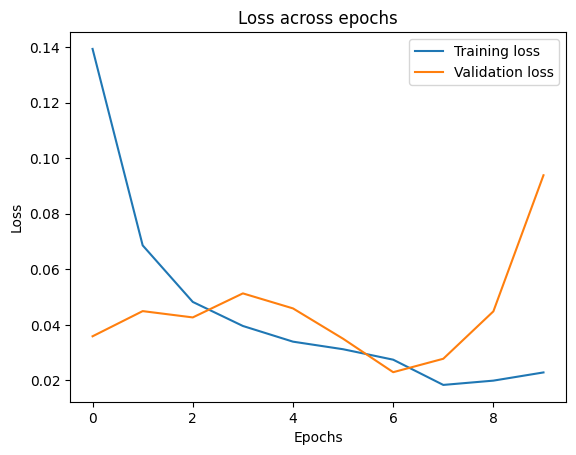

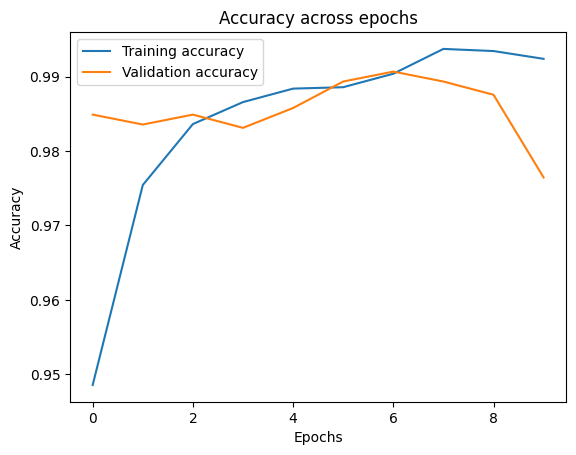

In [ ]:
# Loss and accuracy graph analysis
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss across epochs")
plt.show

plt.figure()
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy across epochs")
plt.show


best_epoch = int(np.argmin(history.history["val_loss"]))
best_val = float(np.min(history.history["val_loss"]))
print(f"Best val_loss = {best_val:.4f} at epoch {best_epoch}")

In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9908 - loss: 0.0337
Test accuracy: 0.992


In [ ]:
# using confusion matrix to tell what the model confuses and why the model might fail giving insights for tuning
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["shoe", "boot", "sandal"]))


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step
[[746   1   3]
 [  1 747   2]
 [  5   6 739]]
              precision    recall  f1-score   support

        shoe       0.99      0.99      0.99       750
        boot       0.99      1.00      0.99       750
      sandal       0.99      0.99      0.99       750

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250



In [ ]:
# Saving the model to preserve architecture, weights, and preprocessing layers
model.save("/content/drive/MyDrive/my_model.keras")


In [ ]:
# Demo test.
from keras.preprocessing import image
demo = files.upload()


Saving 25139894-UsgKUEEC.webp to 25139894-UsgKUEEC (1).webp


In [ ]:
img_filename = list(demo.keys())[0]
img_path = f"/content/{img_filename}"

model = tf.keras.models.load_model(
    "/content/drive/MyDrive/my_model.keras",
    custom_objects={"preprocess_input": preprocess_input})

x = image.img_to_array(image.load_img(img_path, target_size=img_size))
x = np.expand_dims(x, axis=0)

pred = model.predict(x)

print("Raw model output shape:", pred.shape)
print("Raw model output:", pred)
print(class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw model output shape: (1, 3)
Raw model output: [[0.9875195  0.00273646 0.00974401]]
['Boot', 'Sandal', 'Shoe']
